# Asignación de tareas, una forma más Pythonic.

En el presente Notebook se presenta dos formas de asignar las tareas a
distintos agentes con el coste más bajo.

In [1]:
import random
from heapq import heappush, heappop
from typing import Optional, Union, List, Set
import time
from functools import wraps

import matplotlib.pyplot as plt


NumericTypes = Union[int, float, bool]


def measure_time(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.monotonic()
        result = func(*args, **kwargs)
        end_time = time.monotonic()
        elapsed_time = end_time - start_time
        if isinstance(result, tuple) and len(result) == 2 and isinstance(result[1], dict):
            result[1]["time"] = elapsed_time
            return result
        else:
            return result, {"time": elapsed_time}
    return wrapper


def generate_random_task_list(n: int, start: int = 1, stop: int = 100, seed: Optional[int] = None) -> List[List[int]]:
    if seed is not None:
        random.seed(seed)
    return [[random.randrange(start, stop) for _ in range(n)] for _ in range(n)]


class Node:
    def __init__(
            self,
            agent: int,
            task: Optional[int],
            cost: NumericTypes,
            parent: Optional['Node'] = None,
            lower_cost: int = 0
    ):
        self.agent = agent
        self.task = task
        self.parent = parent
        self.cost = cost
        self._accumulative_cost = \
            cost + (0 if self.parent is None else self.parent.accumulative_cost)
        self.lower_bound = self._accumulative_cost + lower_cost

    @property
    def accumulative_cost(self) -> NumericTypes:
        return self._accumulative_cost

    @property
    def satisfied_tasks(self) -> List[int]:
        tasks = []
        current = self
        while current:
            if current.task is not None:
                tasks.append(current.task)
            current = current.parent
        tasks.reverse()
        return tasks

    def __lt__(self, other: 'Node'):
        return self.lower_bound < other.lower_bound

    def __eq__(self, other: 'Node'):
        return self.lower_bound == other.lower_bound

    def __repr__(self):  # for logging purpose
        return f"satisfied:{self.satisfied_tasks}, single_cost: {self.cost}, cost:{self.lower_bound}"


In [2]:
COSTES = [
    #T0, T1, T2, T3
    [11, 12, 18, 40],  # A0
    [14, 15, 13, 22],  # A1
    [11, 17, 19, 23],  # A2
    [17, 14, 20, 28]   # A3
]

## Fuerza bruta pero aplicada de manera inteligente.

Este enfoque utiliza el criteria de Búsqueda de Costos Uniforme, se tomó
cierta inspiración en el algoritmo de Dijkstra.

Este algoritmo por cada iteración, tratará de encontrar la solución de menor
coste; sin embargo, en su proceso de ramificación, no existe control alguno,
lo cual existe la probabilidad de que explore casi todas las permutaciones.

Este algoritmo tiene complejidad $O(N!)$.

In [3]:
@measure_time
def ucs_solver(
        cost_matrix: List[List[int]],
        get_all_solutions: bool = False
) -> List[List[NumericTypes]]:
    """
    Esta variante hace uso de Búsqueda de Costo Uniforme (UCS), hace una
    búsqueda por todos los nodos, y ramifica sin ningún tipo de verificación,
    lo cual lo hace de complejidad O(N!).\n
    Sirve para validar si la solución encontrada es la más corta.\n
    De manera más simple, esta es una variante de *fuerza bruta*, pero
    aplicada de manera inteligente.\n
    Es un algoritmo de exploración exhaustiva que prioriza los caminos más
    prometedores para evitar cálculos innecesarios.\n
    **Complejidad temporal**: *O(N!)*
    :param cost_matrix: Matriz de Costes
    :param get_all_solutions: Por defecto False,
    """
    agents = {i for i in range(len(cost_matrix))}
    tasks = {i for i in range(len(cost_matrix))}

    nodes: List[Node] = []
    [heappush(nodes, Node(0, i, cost_matrix[0][i], None)) for i in agents]
    solutions = []

    while nodes:
        current_node = heappop(nodes)
        satisfied_tasks = current_node.satisfied_tasks
        current_tasks = set(satisfied_tasks)
        available_tasks = tasks - current_tasks
        next_agent = current_node.agent + 1
        if len(current_node.satisfied_tasks) == len(agents):
            if not get_all_solutions:
                return [satisfied_tasks]
            solutions.append(satisfied_tasks)
            continue
        for task in available_tasks:
            child_node = Node(
                agent=next_agent,
                task=task,
                cost=cost_matrix[next_agent][task],
                parent=current_node
            )
            heappush(nodes, child_node)
    return solutions


In [4]:
solution_base_ucs, stats = ucs_solver(COSTES)
print(f"Solution: {solution_base_ucs[0]}, time: {stats['time']}s")

Solution: [0, 2, 3, 1], time: 0.00024898999981814995s


## Ramificación y Poda

Este enfoque se pretende evitar ramificaciones que se intuyen o se sabe que
no van a cumplir el criterio del menor coste.

Para implementar una estrategia algo más inteligente, se usa de igual manera
una cola de prioridad para retornar aquellas respuestas aspirantes a solución
 de manera prioritaria siempre y cuando sean las de menor coste.

La definición del cálculo de la cota inferior se hace a partir de las tareas
que quedan pendientes por cada agente disponible y sin asignación de tareas.

In [5]:
def calculate_lower_cost(
        cost_matrix: List[List[NumericTypes]],
        next_agent: int,
        taken_tasks: Set[int]
) -> int:
    """
    Calcula la suma de los mínimos de las filas restantes, ignorando las
    tareas ya tomadas.

    :param cost_matrix: Matriz de costes
    :param next_agent: Agente desde el que se desea verificar los mínimos
    :param taken_tasks: Tareas ya asignadas previamente
    :return:
    """
    min_future_cost = 0
    num_agents = len(cost_matrix)

    for agent_idx in range(next_agent, num_agents):
        row_min = float('inf')
        for task_idx, cost in enumerate(cost_matrix[agent_idx]):
            if task_idx not in taken_tasks and cost < row_min:
                row_min = cost
        if row_min != float('inf'):
            min_future_cost += row_min

    return min_future_cost

El método `solver` permite bien sea iterar por todas las posibles ramas
candidatas a ser solución, para garantizar encontrar la solución más corta, o
 se puede forzar a que retorne la primera solución de menor costo disponible.

In [6]:
@measure_time
def solver(
        cost_matrix: List[List[int]],
        get_first_searched: bool = False
) -> List[NumericTypes]:
    nodes = []
    num_agents = len(cost_matrix)
    tasks = {i for i in range(len(cost_matrix))}
    best_cost = float('inf')

    root = Node(
        agent=-1, task=None, cost=0,
        lower_cost=calculate_lower_cost(cost_matrix, 0, set())
    )
    solution = None
    heappush(nodes, root)

    while nodes:
        current_node = heappop(nodes)

        if current_node.lower_bound >= best_cost:
            continue
        satisfied_tasks = current_node.satisfied_tasks

        if current_node.agent == num_agents - 1:  # if len(current_satisfied_tasks) == num_agents:
            if get_first_searched:
                return satisfied_tasks
            if current_node.accumulative_cost < best_cost:
                best_cost = current_node.accumulative_cost
                solution = satisfied_tasks
            continue
        current_tasks = set(satisfied_tasks)
        next_agent = current_node.agent + 1
        available_tasks = tasks - current_tasks

        for task in available_tasks:
            current_cost = cost_matrix[next_agent][task]
            current_accumulative_cost = current_node.accumulative_cost + current_cost
            if current_accumulative_cost >= best_cost:
                continue
            remain_tasks = current_tasks.union({task})
            lower_cost = calculate_lower_cost(cost_matrix, next_agent + 1,
                                              remain_tasks)
            child_node = Node(
                agent=next_agent,
                task=task,
                cost=current_cost,
                parent=current_node,
                lower_cost=lower_cost
            )
            if child_node.lower_bound < best_cost:
                heappush(nodes, child_node)

    return solution

In [7]:
solution_base_first, stats = solver(COSTES, True)
print(f"Solution: {solution_base_first}, time: {stats['time']}s")

solution_base_all_explored, stats = solver(COSTES, False)
print(f"Solution: {solution_base_all_explored}, time: {stats['time']}s")

Solution: [0, 2, 3, 1], time: 0.00014932900012354366s
Solution: [0, 2, 3, 1], time: 0.0001662459981162101s


Se hará una prueba de matrices aleatorias con semilla definida, y hasta de 15x15

In [8]:
times = {"UCS": [], "First Solution Pruned": [], "All Solution explored Pruned": []}
for n in range(2,18):
    print(f"{n}x{n} matrix")
    costs = generate_random_task_list(n, seed=47)
    solution_ucs, stats = ucs_solver(costs)
    print(f"Solution UCS: {solution_ucs[0]}, time: {stats['time']}s")
    times["UCS"].append(stats['time'])
    solution_pruned_first, stats = solver(costs, True)
    print(f"First Solution Pruned: {solution_pruned_first}, time: {stats['time']}s")
    times["First Solution Pruned"].append(stats['time'])
    solution_pruned_all, stats = solver(costs)
    print(f"All Solution explored Pruned: {solution_pruned_all}, time: {stats['time']}s")
    times["All Solution explored Pruned"].append(stats['time'])
    assert solution_pruned_all == solution_pruned_first == solution_ucs[0]

2x2 matrix
Solution UCS: [1, 0], time: 2.199099981226027e-05s
First Solution Pruned: [1, 0], time: 2.286000017193146e-05s
All Solution explored Pruned: [1, 0], time: 1.5188998077064753e-05s
3x3 matrix
Solution UCS: [1, 2, 0], time: 3.4270000469405204e-05s
First Solution Pruned: [1, 2, 0], time: 2.8729999030474573e-05s
All Solution explored Pruned: [1, 2, 0], time: 2.6204001187579706e-05s
4x4 matrix
Solution UCS: [1, 3, 2, 0], time: 5.413599865278229e-05s
First Solution Pruned: [1, 3, 2, 0], time: 4.747600178234279e-05s
All Solution explored Pruned: [1, 3, 2, 0], time: 4.5155000407248735e-05s
5x5 matrix
Solution UCS: [1, 4, 2, 0, 3], time: 0.00015412900029332377s
First Solution Pruned: [1, 4, 2, 0, 3], time: 0.00014255399946705438s
All Solution explored Pruned: [1, 4, 2, 0, 3], time: 0.00015434899978572503s
6x6 matrix
Solution UCS: [1, 0, 5, 4, 2, 3], time: 0.00029433500094455667s
First Solution Pruned: [1, 0, 5, 4, 2, 3], time: 0.00010731299698818475s
All Solution explored Pruned: [1, 

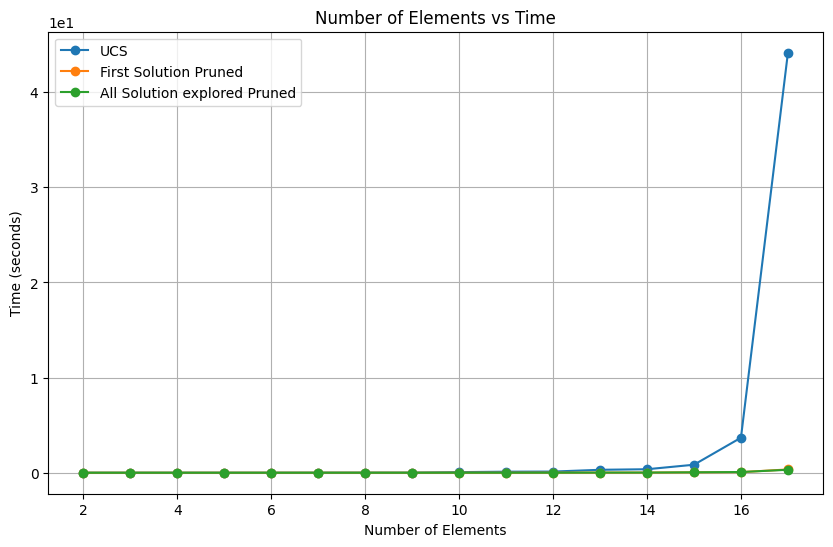

In [9]:
plt.figure(figsize=(10, 6))

for algorithm, _times in times.items():
    num_points = len(_times)
    x_axis = range(2, 2 + num_points)

    plt.plot(x_axis, _times, marker='o', label=algorithm)

plt.title('Number of Elements vs Time')
plt.xlabel('Number of Elements')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.show()

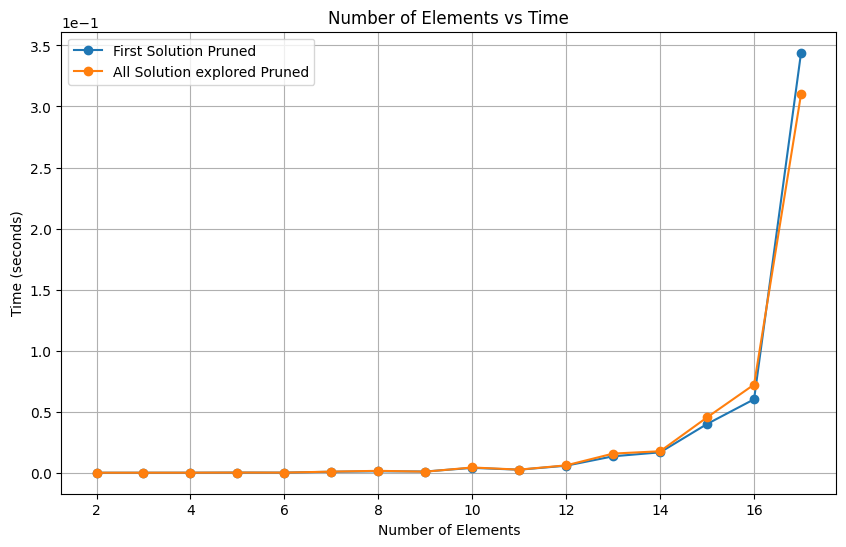

In [10]:
plt.figure(figsize=(10, 6))

for algorithm, _times in times.items():
    if algorithm == "UCS":
        continue
    num_points = len(_times)
    x_axis = range(2, 2 + num_points)

    plt.plot(x_axis, _times, marker='o', label=algorithm)

plt.title('Number of Elements vs Time')
plt.xlabel('Number of Elements')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.show()